### 导入包

In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertTokenizer
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

D:\anaconda\envs\nn6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\anaconda\envs\nn6\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
D:\anaconda\envs\nn6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\nn6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

### 加载数据

In [2]:
def byte2str(data):
    data = list(data)
    for i, item in enumerate(data):
        data[i] = item.decode('utf-8')
    return data

def load_dataset(file_path, train_ratio=0.8, random_seed=1):
    # Load the dataset from the file
    with h5py.File( file_path , 'r') as f:
        data = {}
        for key in f.keys():
            data[key] = np.array(f[key])

    # Shuffle the data indices
    num_examples = len(data['labels'])
    indices = np.arange(num_examples)
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(indices)

    # Split the data into training and testing sets
    split_index = int(num_examples * train_ratio)
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    train_data = {key: data[key][train_indices] for key in data}
    test_data = {key: data[key][test_indices] for key in data}
    
    train_data['texts'], train_data['labels'] = byte2str(train_data['texts']), byte2str(train_data['labels'])
    test_data['texts'], test_data['labels'] = byte2str(test_data['texts']), byte2str(test_data['labels'])
    
    label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
    train_data['labels_ids'] = [label2id[label] for label in train_data['labels']]
    test_data['labels_ids'] = [label2id[label] for label in test_data['labels']]
    
    return (np.array(train_data['images']), np.array(train_data['texts']), np.array(train_data['labels']),
            np.array(train_data['labels_ids']), np.array(test_data['images']), np.array(test_data['texts']),
            np.array(test_data['labels']), np.array(test_data['labels_ids'])) 

In [3]:
file_path = 'MVSA_Single/dataset.h5'
train_data , test_data = {} , {} 
train_data['image'], train_data['text'], train_data['label'], train_data['labels_id'],\
test_data['image'], test_data['text'], test_data['label'], test_data['labels_id']\
= load_dataset(file_path)

### 预处理文本

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def text2token(texts, maxlen):
    tokens = tokenizer.batch_encode_plus(texts,
                                         max_length=maxlen,
                                         padding='max_length',
                                         truncation=True,
                                         return_tensors='pt')
    input_ids = tokens['input_ids']

    
    return input_ids

In [5]:
train_data['input_ids'] = text2token(train_data['text'],30)
test_data['input_ids'] = text2token(test_data['text'],30)

### 定义ImageModel

In [6]:
class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        #加载VGG16预训练模型
        self.vgg16 = models.vgg16(pretrained=True)
        # 去掉全连接层
        self.features = nn.Sequential(*list(self.vgg16.children())[:-1])
        # 冻结参数
        for param in self.features.parameters():
            param.requires_grad = False
        # 添加新的全连接层以便训练任务
        self.fc1 = nn.Linear(512 * 7 * 7, 256)
 
    def forward(self, x_image):
        # 将图像作为VGG16的输入
        features = self.features(x_image)
        # 将输出的特征展开
        flatten = nn.Flatten()(features)
        # 用全连接层提取特征
        fc1_out = self.fc1(flatten)

        return fc1_out
        

### 定义TextModel

In [7]:
class TextModel(nn.Module):
    def __init__(self, model_name):
        super(TextModel, self).__init__()
        # 加载预训练模型和tokenizer
        self.embedding = BertModel.from_pretrained(model_name)
#         # 定义线性层，用于输出分类结果
#         self.fc = nn.Linear(self.embedding.config.hidden_size, num_classes)
        
    def forward(self, x):
        input_ids = x
        # 获取BERT编码特征
        with torch.no_grad():
            embedding_output = self.embedding(input_ids=input_ids)[0]
            # 取最后一层的输出作为特征表示
            features = embedding_output[:, 0, :]
        
#         # 使用全连接层进行分类
#         logits = self.fc(features)
#         return logits
        return features

### 定义FusionModel

In [8]:
class FusionModel(nn.Module):
    def __init__(self, model_name, num_classes, dropout_prob = 0.5):
        super(FusionModel, self).__init__()
        self.num_classes = num_classes
        self.TextModel = TextModel(model_name=model_name)
        self.ImageModel = ImageModel()
        # 定义融合后的全连接层
        self.fusion_fc = nn.Sequential(
            nn.Linear(256 + 768, 128),
            nn.ReLU(),
            # -------05/01-------------修改部分--------------------
            nn.Dropout(p=dropout_prob),
            # -------05/01-------------修改部分--------------------
            nn.Linear(128, num_classes)
        )
        self.to('cuda')
        
    def forward(self, x):
        x_image = x['image']
        x_text = x['input_ids']
        feature_image_out = self.ImageModel(x_image)
        feature_text_out = self.TextModel(x_text)
        #将文本特征和图像特征拼接在一起
        fusion_fea = torch.cat((feature_image_out, feature_text_out), dim=1)
        # 对融合后的特征进行全连接层操作
        y_pred = self.fusion_fc(fusion_fea)
        
        return y_pred

### 模型实例化

In [9]:
MyModel = FusionModel(model_name='bert-base-uncased', num_classes=3)

### 定义Dataset和Loader

In [10]:
class Dataset(Dataset):
    def __init__(self, data):
        self.image = data['image']
        self.input_ids = data['input_ids']
        self.labels_id = torch.tensor(data['labels_id'])
    
    def __len__(self):
        return len(self.image)
        
    def __getitem__(self, index):
        image = self.image[index]
        image = image.transpose((2, 0, 1))
        # 转换图像数据类型为 float32
        image = image.astype('float32')
        # 归一化图像数据到 [0, 1] 区间
        image /= 255
        input_ids = self.input_ids[index]
        y = self.labels_id[index]

        return {'image': image, 'input_ids':input_ids,
                'labels_id': y}

### 数据集实例化

In [11]:
train_dataset = Dataset(train_data)
test_dataset = Dataset(test_data)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

### 定义损失函数和优化器

In [12]:
import torch.optim as optim
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(MyModel.parameters(), lr=0.001\
#                        , weight_decay=0.01\
                      )

### 训练模型

In [13]:
import matplotlib.pyplot as plt
# 训练模型
loss_list = []
Acc = []
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # 获取输入数据和标签
        image, inputs_ids = data['image'], data['input_ids']
        labels = data['labels_id'].long()
        image = image.to('cuda')
        inputs_ids = inputs_ids.to('cuda')
        labels = labels.to('cuda')
        {'image':image, 'input_ids':inputs_ids}
        # 将梯度归零
        optimizer.zero_grad()
        # 前向传递
        outputs = MyModel({'image':image, 'input_ids':inputs_ids})
        # 计算损失
        # 一个batch中所有样本的平均损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()
        # 统计损失值
        running_loss += loss.item() 
         # 统计准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        #  05/01 修改loss
        # 每 10 批次打印一次统计信息
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10, correct / total))
            # -------05/01-------------修改部分--------------------
            loss_list.append(running_loss) 
            Acc.append(correct / total)
            # -------05/01-------------修改部分--------------------
            running_loss = 0.0    
#         epoch_loss = running_loss / batch_size
#         loss_list.append(epoch_loss)
        
        
#         # 每 10 批次打印一次统计信息
#         if i % 10 == 9:
#             print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 10, correct / total))
#             running_loss = 0.0
        
#         epoch_loss = running_loss / len(train_loader)
#         loss_list.append(epoch_loss)
        


[1,    10] loss: 1.352, accuracy: 0.362
[1,    20] loss: 1.169, accuracy: 0.367
[1,    30] loss: 1.130, accuracy: 0.367
[1,    40] loss: 1.093, accuracy: 0.366
[1,    50] loss: 1.089, accuracy: 0.362
[1,    60] loss: 1.103, accuracy: 0.364
[1,    70] loss: 1.124, accuracy: 0.355
[1,    80] loss: 1.095, accuracy: 0.357
[1,    90] loss: 1.097, accuracy: 0.362
[1,   100] loss: 1.099, accuracy: 0.359
[1,   110] loss: 1.079, accuracy: 0.359
[1,   120] loss: 1.084, accuracy: 0.358
[2,    10] loss: 1.060, accuracy: 0.378
[2,    20] loss: 1.057, accuracy: 0.400
[2,    30] loss: 1.046, accuracy: 0.419
[2,    40] loss: 1.016, accuracy: 0.432
[2,    50] loss: 1.018, accuracy: 0.449
[2,    60] loss: 1.059, accuracy: 0.452
[2,    70] loss: 1.047, accuracy: 0.455
[2,    80] loss: 1.057, accuracy: 0.454
[2,    90] loss: 1.030, accuracy: 0.451
[2,   100] loss: 1.044, accuracy: 0.455
[2,   110] loss: 1.016, accuracy: 0.457
[2,   120] loss: 1.057, accuracy: 0.457
[3,    10] loss: 0.914, accuracy: 0.547


KeyboardInterrupt: 

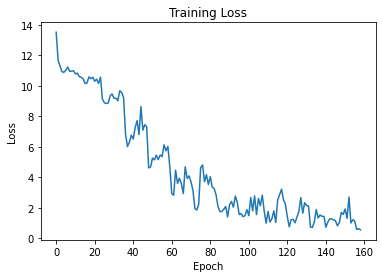

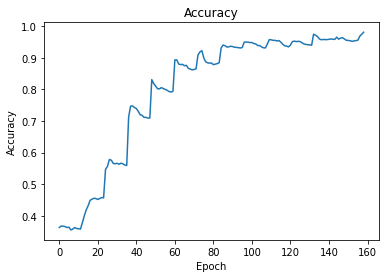

In [14]:
# 绘制loss下降图
plt.plot(loss_list)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 绘制Acc图
plt.plot(Acc)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

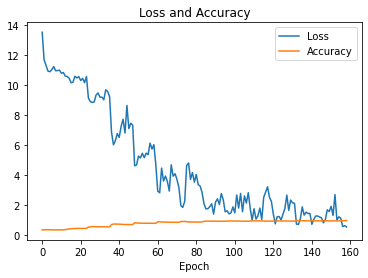

In [15]:
plt.plot(loss_list, label = 'Loss')
plt.plot(Acc, label = 'Accuracy')
plt.title('Loss and Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(Acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
# 创建一个figure对象和Axes对象
fig, ax = plt.subplots()

# 在左侧y轴上绘制loss图
ax.plot(loss_list, color='blue')
ax.set_ylabel('Loss', color='blue')
ax.tick_params(axis='y')

# 在右侧y轴上绘制accuracy图
ax2 = ax.twinx()
ax2.plot(Acc, color='orange')
ax2.set_ylabel('Accuracy', color='orange')
ax2.tick_params(axis='y')

# 设置x轴标签和标题
ax.set_xlabel('Epoch')
ax.set_title('Loss and Accuracy')

# 设置y轴范围
ax.set_ylim([0, 14])
ax2.set_ylim([0.35, 1])

# 显示图像
plt.show()

### 测试集Loss&Acc

In [ ]:
correct = 0
total = 0
test_acc_list = []
# 在测试集上禁用dropout和梯度计算
MyModel.eval()

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        # 将数据移动到GPU（如果有的话）
        image, inputs_ids = data['image'], data['input_ids']
        labels = data['labels_id'].long()
        image = image.to('cuda')
        inputs_ids = inputs_ids.to('cuda')
        labels = labels.to('cuda')
        {'image':image, 'input_ids':inputs_ids}
        # 将梯度归零
        optimizer.zero_grad()
        # 前向传递
        outputs = MyModel({'image':image, 'input_ids':inputs_ids})
        _, predicted = torch.max(outputs.data, 1)

        # 统计正确预测的样本数和总样本数
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #  05/01 修改loss
        # 每 10 批次打印一次统计信息
        if i % 10 == 9:
            print('[%d, %5d]：accuracy: %.3f' %
                  (epoch + 1, i + 1, correct / total))
            # -------05/01-------------修改部分--------------------
            test_acc_list.append(correct / total)
            # -------05/01-------------修改部分--------------------
            running_loss = 0.0

[14,    10]：accuracy: 0.425
[14,    20]：accuracy: 0.408


In [ ]:
accuracy = 100 * correct / total
print('Accuracy on the test set: %.2f%%' % accuracy)

In [ ]:
plt.plot(test_acc_list)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()